# Linear regression

Qui ci sono un po' di esercizi sulla Regressione lineare, svolti sia con NumPy che con PyTorch, da database di SkLearn. Affronto sia la regressione lineare con la normal equation che con il gradient descent.

## Fitting with the exact solution

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%matplotlib inline

### A simple dataset

In [49]:
dataset = torch.tensor([[1,3],
                        [1.11, 3.06],
                        [1.2, 3.3],
                        [1.3, 3.4],
                        [1.43, 3.7],
                        [1.6, 3.5],
                        [1.8, 3.66],
                        [1.87, 3.82],
                        [2.1,4]], dtype = torch.float)

x = dataset[:,0]     # we select the first feature of all points
y = dataset[:,1]     # we select the second feature of all points

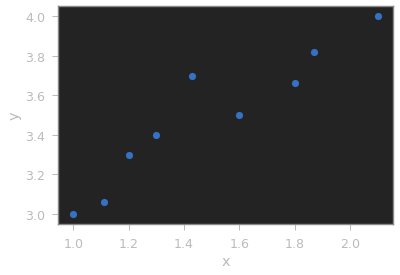

In [50]:
plt.scatter(x,y)

plt.xlabel("x")
plt.ylabel("y")

plt.show()

Linear regression is the simplest machine learning algorithm. It is used to model the relationship between two variables: a dependent variable (y) and an independent variable (x). The goal is to find the best-fitting linear equation that describes the relationship between these variables. The "best" fit will be the line that minimizes the sum of squared residuals (the least-squares approach)

Given a loss functions defined as:

$ \mathcal{L} = \mathbb{E}[(y - ax - b)^2]$

The [optimal parameters](https://en.wikipedia.org/wiki/Simple_linear_regression) to minimize the loss are:

$ a = \dfrac{\sigma_{x,y}}{\sigma^2_x}$

$ b = \bar{y} - a \bar{x}$

In [51]:
covariance = (x.dot(y) / (y.shape[0]) - x.mean() * y.mean()) # numeratore miglior stima di a

a =  covariance / x.var(unbiased=False)             # correction = 0 is used to divide 
                                                    # by n and not n-1 (qui unbiased=False)
b = y.mean() - a * x.mean()

a, b

(tensor(0.8415), tensor(2.2395))

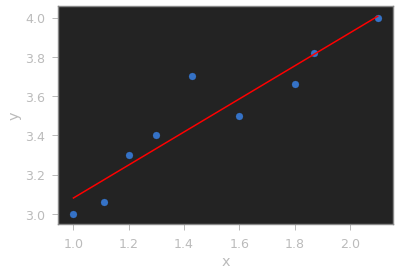

In [52]:
plt.scatter(x,y)
plt.plot(x, a*x + b, color = "red")

plt.xlabel("x")
plt.ylabel("y")

plt.show()

In [53]:
best_mse = ((a*x + b - y)**2).mean(); best_mse

tensor(0.0121)

### Diabetes: NumPy - Pandas

#### Dataset

Carico i dati e, su 200, ne assegno 150 al training set

In [ ]:
number_examples = 200
number_sample_train = 150
diabetes = datasets.load_diabetes()
X = diabetes.data[:number_examples]
y = diabetes.target[:number_examples]

In [ ]:
X_centered = X   # inizializzo semplicemente X_centered
for i in range(X.shape[1]):
    X_centered[:,i]=(X[:,i]-X[:,i].mean())   # se faccio feature normalization c'è qualcosa che non va
    
y_centered = (y-y.mean())

#### Modelli

##### Mio algoritmo

In [ ]:
# Funzioni per la regressione lineare

# Calcola pseudoinversa con ridge regression

def calcola_pseudo_inv(X,lambda_reg=0):
    n = X.shape[1]
    pseudo_inv = np.dot((np.linalg.inv(np.dot(X.T,X)+lambda_reg*np.identity(n))),X.T)  
    return(pseudo_inv)

def calcola_w_ML(X,y,lambda_reg=0):
    A = calcola_pseudo_inv(X,lambda_reg)
    w_ML = np.dot(A,y)
    return(w_ML)

def predict(X,w):           # regressione lineare, data la design matrix e vettore parametri
    y_predict = np.dot(X,w)
    return(y_predict)

# errore con ridge regression

def errore(y,y_predict,w,lambda_reg=0):
    m = len(y)
    diff = y-y_predict
    err = (np.dot(diff.T,diff)+lambda_reg*np.dot(w.T,w))/m
    return(err)

def r2(y,y_predict):
    RSS = ((y-y_predict)**2).sum()
    TSS = ((y-y.mean())**2).sum()
    r2 = 1- RSS/TSS
    return(r2)

In [ ]:
df = pd.DataFrame(data=X_centered)       # uso pandas così maneggio facilmente il database
df.insert(0,'x0',1)          # aggiungo una colonna di 1 per il peso relativo al bias
Design_Matrix = df.to_numpy()
D_train, D_test = Design_Matrix[:number_sample_train], Design_Matrix[number_sample_train:]
y_train, y_test = y_centered[:number_sample_train], y_centered[number_sample_train:]

w_ML = calcola_w_ML(D_train,y_train,lambda_reg=10)
y_predict = predict(D_test,w_ML)
err_T = errore(y_train,np.dot(D_train,w_ML),w_ML,lambda_reg=10)
err_g = errore(y_test,y_predict,w_ML,lambda_reg=10)

##### Sklearn Linear Regression

In [ ]:
diabetes_X_train, diabetes_X_test = X[:number_sample_train], X[number_sample_train:]
diabetes_y_train, diabetes_y_test = y[:number_sample_train], y[number_sample_train:]

regr = linear_model.LinearRegression()
ridge = linear_model.Ridge()

regr.fit(diabetes_X_train, diabetes_y_train)
diabetes_y_pred = regr.predict(diabetes_X_test)

# provo Ridge regression via Sklearn

ridge.set_params(alpha=10)     # alpha è quello che io ho chiamato lambda_reg
ridge.fit(diabetes_X_train, diabetes_y_train);

#### Confronto tra i risultati

In [ ]:
print("Coefficienti linear model sklearn: \n", regr.coef_)
print('')
print('''Coefficienti mio algoritmo: 
''',w_ML)
print('')
print("Coefficienti Ridge regression: \n", ridge.coef_)
print('')

#### Confronto tra gli errori

##### Sklearn

In [ ]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))


##### Mio algoritmo

In [ ]:
print('In sample error: %.2f' %err_T)
print('Out of sample error: %.2f' %err_g)

In [ ]:
ridge.score(diabetes_X_test,diabetes_y_test)  # R2 score, devo fare lo stesso per il mio algoritmo

In [ ]:
regr.score(diabetes_X_test,diabetes_y_test)

In [ ]:
r2 = r2(y_test,y_predict)

r2

In [ ]:
diabetes_X_train.shape

### Diabetes: PyTorch

In [ ]:
# we import the diabetes dataset

X = torch.tensor(diabetes.data, dtype = torch.float)   # features
y = torch.tensor(diabetes.target, dtype = torch.float) # label (dopo quanto tempo peggiora la malattia)

number_sample_train = 150
y = y / y.max() # normalizziamo le labels per avere Loss che non esplodano

#### Mio algoritmo

In [ ]:
def calcola_pseudo_inv(X,lambda_reg=0):
    n = X.shape[1]
    pseudo_inv = torch.matmul((torch.inverse(torch.matmul(X.T,X)+lambda_reg*torch.eye(n))),X.T)  
    return(pseudo_inv)

def calcola_w_ML(X,y,lambda_reg=0):
    A = calcola_pseudo_inv(X,lambda_reg)
    w_ML = torch.matmul(A,y)
    return(w_ML)

def predict(X,w):           # regressione lineare, data la design matrix e vettore parametri
    y_predict = torch.matmul(X,w)
    return(y_predict)

# errore con ridge regression

def errore(y,y_predict,w,lambda_reg=0):
    m = len(y)
    diff = y-y_predict
    err = (torch.matmul(diff.T,diff)+lambda_reg*torch.matmul(w.T,w))/m
    return(err)

def r2(y,y_predict):
    RSS = ((y-y_predict)**2).sum()
    TSS = ((y-y.mean())**2).sum()
    r2 = 1- RSS/TSS
    return(r2)

In [ ]:
bias = torch.tensor([[1]]*X.size()[0])
Design_Matrix = torch.cat((X,bias),1)
D_train, D_test = Design_Matrix[:number_sample_train], Design_Matrix[number_sample_train:]
y_train, y_test = y[:number_sample_train], y[number_sample_train:]

w_ML = calcola_w_ML(D_train,y_train,lambda_reg=0)
y_predict = predict(D_test,w_ML)
err_T = errore(y_train,torch.matmul(D_train,w_ML),w_ML,lambda_reg=0)
err_g = errore(y_test,y_predict,w_ML,lambda_reg=0)

#### Sklearn Linear Regression

In [ ]:
diabetes_X_train, diabetes_X_test = X[:number_sample_train], X[number_sample_train:]
diabetes_y_train, diabetes_y_test = y[:number_sample_train], y[number_sample_train:]

regr = linear_model.LinearRegression()
ridge = linear_model.Ridge()

regr.fit(diabetes_X_train, diabetes_y_train)
diabetes_y_pred = regr.predict(diabetes_X_test)

# provo Ridge regression via Sklearn

ridge.set_params(alpha=0)     # alpha è quello che io ho chiamato lambda_reg
ridge.fit(diabetes_X_train, diabetes_y_train);

#### Confronto tra i risultati

In [ ]:
print("Coefficienti linear model sklearn: \n", regr.coef_)
print('')
print('''Coefficienti mio algoritmo: 
''',w_ML)
print('')
print("Coefficienti Ridge regression: \n", ridge.coef_)
print('')